# Exploring SINDy

In [270]:
import numpy as np
from scipy.integrate import solve_ivp
import matplotlib.pyplot as plt
import pysindy as ps

### Notes
- we can use solve_ivp to generate some trajectories, although i don't know how this scales for 2nd order systems yet
- `model.fit` carries out the augmentation and OLS regression -- use this at the latent scale 
- `model.predict` computes derivatives using estimated SINDy coefs
- `model.differentiate` computes first differences to get the derivatives (has knowledge of the time steps)
- they probably flattened the image data since it's much easier to compute the network gradients to propogate the actual derivative information through to the latent 

### Ideas
- first generate data flat to screen, then consider in frame rotations, or arial view with movement on diagonal 
- we could do both approaches for the SINDy AE model; use Legenre polynomials to augment the dimension similar to the Lorenz system, or we could make a movie out of it. 
    - might be worth exploring both of these options, mainly just to get a baseline to see if it can recover the data when we use a naive augmentation 
- define the function to generate spring data, return the coefficients used to build it as well so we can compare with SINDy
- maybe compare a fully deep approach to SINDy AE in terms of predictive abilities 
- use a really good feature extractor like VGG or something before the fully connected layers in the autoencoder?

In [57]:
#let's see if scipy.integrate works as expected -- generating trajectories 
dt = .002
t = np.arange(0, 5, dt)

f = lambda t, y: 0.5*y 
x0 = np.expand_dims(np.array(1),-1)

x_train = solve_ivp(f, 
                    t_span = (t[0], t[-1]), 
                    y0 = x0,
                    t_eval = t).y.T


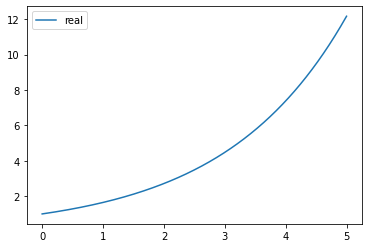

In [61]:
plt.plot(t, x_train)
#plt.plot(t, np.exp(t))


In [59]:
#kinda cool 
model = ps.SINDy()
model.fit(x_train, t=dt)
model.print()

(x0)' = 0.500 x0


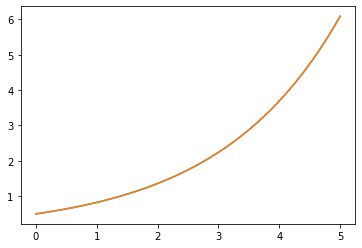

In [60]:
preds = model.predict(x_train) #just finite differences I think 
real = np.array([f(t,x) for t, x in zip(t,x_train)])

plt.plot(t,preds)
plt.plot(t,real)

# Harmonic Oscillator 
We have the following ODE for a damped harmonic oscilaltor: $x'' + cx' + \frac{k}{m}x = 0$, where $k$ is **finish this later**


### TODO 
- write some code to turn the positional information into a video frame 
- look into how image/videos work in python & generate a little vid 
- understand how they pass the derivative information into the network (pixel by pixel?)

## 1. generate raw dynamics

In [228]:
spring_f = lambda t, x, params: [x[1], -params['c']*x[1]-(params['k']/params['m'])*x[0]]

dt = .2
t = np.arange(0, 20, dt)

#vary c to change the damping behaviour 
params = {'c':0.33, 'm':0.5, 'k':1}

x0 = [1, 0]

x_train = solve_ivp(lambda t,x: spring_f(t,x,params), 
                    t_span = (t[0], t[-1]), 
                    y0 = x0,
                    t_eval = t).y.T

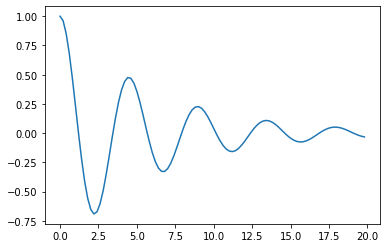

In [229]:
#okay that worked, kinda siiiccckkkk
plt.plot(t, x_train[:,0])

In [230]:
#verify that we can recover the data -- we can 
model = ps.SINDy()
model.fit(x_train, t=dt)
model.print()

(x0)' = 0.987 x1
(x1)' = -1.984 x0 + -0.323 x1


## 2. Turn dynamics into a movie 
- they explicitly provide the dynamics, but couldn't we compute them through differencing? My theory is that the discrepancy between the two should shrink as we increase the size of the image.  Just tested it and yea it significantly reduced the error!


In [255]:
def spring_to_movie(x, dt=0.01, dim = 100):
    """
    naive implementation of the function provided in the pendulum example.  in the case where our images are large
    the discrepancy between the differencing scheme and the explicit derivatives should be neglibible. 
    
    maybe later we should compute these for realz
    
    todo:
    - explicit derivatives instead of differencing scheme
    - scale it up a bit to consider the number of initial conditions we're considering (like they did, batch info tf)
    - location and scale params for size and framing of the mass in frame 
    """
    
    #note the ordering on y (i'm guessing they did it so the top-down convention is reversed)
    y1,y2 = np.meshgrid(np.linspace(1.5,-1.5,dim),np.linspace(1.5,-1.5,dim)) 
    
    #defining a guassian over the image centered where our point mass is 
    create_image = lambda x : np.exp(-((y1 - x)**2 + (y2 - 0)**2)/.05)
    
    nsamples = x.shape[0]
    
    z = np.zeros((nsamples, dim, dim))
    dz = np.zeros((nsamples, dim, dim))
    ddz = np.zeros((nsamples, dim, dim))
    
    #create images 
    for i in range(nsamples):
        z[i] = create_image(x[i])
        
    
    #generate first derivative (we could easily do this way more efficiently but hey)
    #i'm assuming the object starts from rest so that dz|0 = ddz|0 = 0
    for i in range(nsamples-2):
        dz[i+1] = (z[i+2]-z[i])/(2*dt) #centered differencing
    
    dz[-1] = -(z[-1]-z[-2])/dt #backwards scheme
            
        
    #second derivatives
    ddz[1] = (dz[1]-dz[0])/dt
    for i in range(nsamples-3):
        ddz[i+2] = (dz[i+3]-dz[i+1])/(2*dt)
    
    ddz[-1] = -(dz[-1]-dz[-2])/dt    
    
    return z,dz,ddz
    

In [256]:
z,dz,ddz = spring_to_movie(x_train[:,0])

Text(0.5, 1.0, 'ddz')

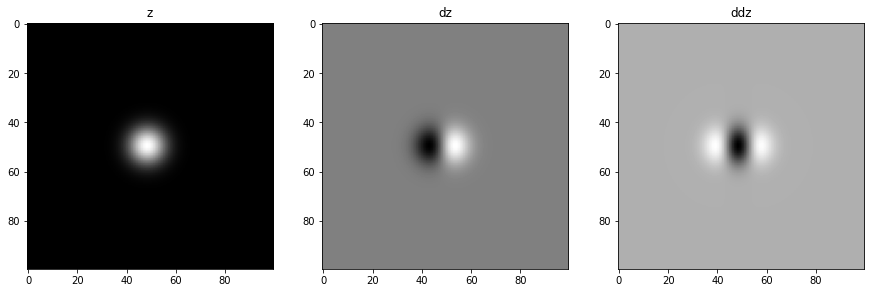

In [269]:
fig, ax = plt.subplots(1,3, figsize=(15,5))

i = 50
ax[0].imshow(z[i], cmap = "gray")
#ax[0].axis('off')
ax[0].set_title('z')

ax[1].imshow(dz[i], cmap = "gray")
#ax[1].axis('off')
ax[1].set_title('dz')

ax[2].imshow(ddz[i], cmap = "gray")
#ax[2].axis('off')
ax[2].set_title('ddz')


In [258]:
#writing the files to the directory takes a little bit of time, consider using fewer imgs 
import imageio

In [266]:
#i think the idea is that we first need to save a bunch of images 
gif_dir = './gif_src/'
for i, f in enumerate(z):
    plt.imshow(f, cmap = "gray")
    plt.axis('off')
    plt.savefig(gif_dir+f's{i}')
    plt.close()

In [267]:
import os
import re 

gif_files = [os.path.join(gif_dir, f) for f in os.listdir(gif_dir)]
gif_files.sort(key = lambda x: int(re.findall(r'\d+', x)[0])) #make sure they're sorted 
gif_files

['./gif_src/s0.png',
 './gif_src/s1.png',
 './gif_src/s2.png',
 './gif_src/s3.png',
 './gif_src/s4.png',
 './gif_src/s5.png',
 './gif_src/s6.png',
 './gif_src/s7.png',
 './gif_src/s8.png',
 './gif_src/s9.png',
 './gif_src/s10.png',
 './gif_src/s11.png',
 './gif_src/s12.png',
 './gif_src/s13.png',
 './gif_src/s14.png',
 './gif_src/s15.png',
 './gif_src/s16.png',
 './gif_src/s17.png',
 './gif_src/s18.png',
 './gif_src/s19.png',
 './gif_src/s20.png',
 './gif_src/s21.png',
 './gif_src/s22.png',
 './gif_src/s23.png',
 './gif_src/s24.png',
 './gif_src/s25.png',
 './gif_src/s26.png',
 './gif_src/s27.png',
 './gif_src/s28.png',
 './gif_src/s29.png',
 './gif_src/s30.png',
 './gif_src/s31.png',
 './gif_src/s32.png',
 './gif_src/s33.png',
 './gif_src/s34.png',
 './gif_src/s35.png',
 './gif_src/s36.png',
 './gif_src/s37.png',
 './gif_src/s38.png',
 './gif_src/s39.png',
 './gif_src/s40.png',
 './gif_src/s41.png',
 './gif_src/s42.png',
 './gif_src/s43.png',
 './gif_src/s44.png',
 './gif_src/s45.png'

In [268]:
# build gif
with imageio.get_writer('spring1.gif', mode='I') as writer:
    for filename in gif_files:
        image = imageio.imread(filename)
        writer.append_data(image)
        
# Remove files
for filename in gif_files:
    os.remove(filename)

<ipython-input-268-fea31f2e969b>:4: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  image = imageio.imread(filename)


# Tensorflow stuff
- Update: this is making my brain hurt, let's see if we can just use the author's code for this instead 
- yea the code for this is in the *z_derivative* function of the `autoencoders.py` script

In [271]:
import tensorflow as tf
import tensorflow.keras as tfk

In [282]:
#quick model 
def my_init(shape, dtype=None):
    return 1*tf.ones(shape, dtype=dtype)

input_layer = tfk.layers.Input(shape=(1,1))
hidden = tfk.layers.Dense(units = 2, activation = 'sigmoid', kernel_initializer = my_init)(input_layer)
output_layer = tfk.layers.Dense(units = 1, activation = 'sigmoid', kernel_initializer = my_init)(hidden)

model = tfk.Model(input_layer, output_layer)
model.summary()

Model: "model_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_9 (InputLayer)        [(None, 1, 1)]            0         
                                                                 
 dense_9 (Dense)             (None, 1, 2)              4         
                                                                 
 dense_10 (Dense)            (None, 1, 1)              3         
                                                                 
Total params: 7
Trainable params: 7
Non-trainable params: 0
_________________________________________________________________


In [283]:
model.weights

[<tf.Variable 'dense_9/kernel:0' shape=(1, 2) dtype=float32, numpy=array([[1., 1.]], dtype=float32)>,
 <tf.Variable 'dense_9/bias:0' shape=(2,) dtype=float32, numpy=array([0., 0.], dtype=float32)>,
 <tf.Variable 'dense_10/kernel:0' shape=(2, 1) dtype=float32, numpy=
 array([[1.],
        [1.]], dtype=float32)>,
 <tf.Variable 'dense_10/bias:0' shape=(1,) dtype=float32, numpy=array([0.], dtype=float32)>]

In [294]:
#just making sure the behaviour is right 
data = tf.constant(0, dtype = float, shape = (1,1))
print(model(data))
print(1/(1+np.exp(-1)))

tf.Tensor([[[0.7310586]]], shape=(1, 1, 1), dtype=float32)
0.7310585786300049


In [393]:
with tf.GradientTape(persistent=True) as g:
    g.watch(data)
    
    #feedforward ugh
    z = data
    
    activations = []
    hidden = [z]
    
    for i in range(len(model.weights)//2):
        z = tf.matmul(z, model.weights[2*i]) + model.weights[2*i+1]
        a = tfk.activations.sigmoid(z)
        activations.append(a)
        hidden.append(z)
        a = z

In [398]:
g.gradient(activations, hidden)

[<tf.Tensor: shape=(1, 1), dtype=float32, numpy=array([[1.]], dtype=float32)>,
 <tf.Tensor: shape=(1, 2), dtype=float32, numpy=array([[0.5, 0.5]], dtype=float32)>,
 <tf.Tensor: shape=(1, 1), dtype=float32, numpy=array([[0.25]], dtype=float32)>]

In [397]:
activations

[<tf.Tensor: shape=(1, 2), dtype=float32, numpy=array([[0.5, 0.5]], dtype=float32)>,
 <tf.Tensor: shape=(1, 1), dtype=float32, numpy=array([[0.5]], dtype=float32)>]

In [392]:
activations[0]

<tf.Tensor: shape=(1, 2), dtype=float32, numpy=array([[0.5, 0.5]], dtype=float32)>